# NEXRAD data

Is it raining in Miami?

The Next Generation Weather Radar (NEXRAD) system is a network of 160 high-resolution S-band Doppler weather radars jointly operated by the National Weather Service (NWS), the Federal Aviation Administration (FAA), and the U.S. Air Force. The NEXRAD system detects precipitation and wind, and its data can be processed to map precipitation patterns and movement. NCEI provides access to archived NEXRAD Level-II data and Level-III products. [source](https://www.ncei.noaa.gov/products/radar/next-generation-weather-radar)

The NEXRAD data is freely available on the Amazon cloud at [https://registry.opendata.aws/noaa-nexrad/](https://registry.opendata.aws/noaa-nexrad/).

The data can be accessed using the Python ARM Radar Toolkit ([Py-ART](https://arm-doe.github.io/pyart/)), an open source library for working with weather radar data. Py-ART is partly supported by the U.S. Department of Energy as part of the Atmospheric Radiation Measurement (ARM) Climate Research Facility, an Office of Science user facility. Which was developed by JJ Helmus and SM Collis (JORS 2016, doi: 10.5334/jors.119)

[PyArt examples](https://projectpythia.org/radar-cookbook/notebooks/foundations/pyart-basics.html)

Here we use PyArt to find recent files from the Miami NEXRAD station and look at Miami to see if it is raining.

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import tempfile
import pytz
from datetime import datetime
import pyart
import xarray as xr
from datetime import datetime, timedelta

templocation = tempfile.mkdtemp()

In [25]:
import nexradaws
conn = nexradaws.NexradAwsInterface()

In [83]:
from datetime import datetime, timedelta
# Get today's date
date_start = datetime.today()
date_end = date_start - timedelta(hours=18)
lyr,imon,idym = date_start.year, date_start.month, date_start.day
lyr_start,imon_start,idym_start,ihr_start = date_start.year, date_start.month, date_start.day,date_start.hour
lyr_end,imon_end,idym_end,ihr_end = date_end.year, date_end.month, date_end.day,date_end.hour

In [84]:
#KAMX
availscans = conn.get_avail_scans(lyr,imon,idym, 'KAMX')
print("There are {} NEXRAD files available for today for the KAMX radar.\n".format(len(availscans)))
print(availscans[0:4])

There are 246 NEXRAD files available for today for the KAMX radar.

[<AwsNexradFile object - 2024/09/09/KAMX/KAMX20240909_000409_V06>, <AwsNexradFile object - 2024/09/09/KAMX/KAMX20240909_000911_V06>, <AwsNexradFile object - 2024/09/09/KAMX/KAMX20240909_001359_V06>, <AwsNexradFile object - 2024/09/09/KAMX/KAMX20240909_001848_V06>]


In [87]:
ny_timezone = pytz.timezone('America/New_York')
radar_id = 'KAMX'
start = ny_timezone.localize(date_start)
end = ny_timezone.localize (date_end)
scans = conn.get_avail_scans_in_range(end, start, radar_id)
print("There are {} scans available between {} and {}\n".format(len(scans), start, end))
print(scans[-4:-1])

There are 249 scans available between 2024-09-09 11:35:37.809821-04:00 and 2024-09-08 17:35:37.809821-04:00

[<AwsNexradFile object - 2024/09/09/KAMX/KAMX20240909_152040_V06>, <AwsNexradFile object - 2024/09/09/KAMX/KAMX20240909_152500_V06>, <AwsNexradFile object - 2024/09/09/KAMX/KAMX20240909_153012_V06>]


In [88]:
results = conn.download(scans[0:4], templocation)

Downloaded KAMX20240908_213701_V06
Downloaded KAMX20240908_214503_V06
Downloaded KAMX20240908_214903_V06
Downloaded KAMX20240908_214102_V06
4 out of 4 files downloaded...0 errors


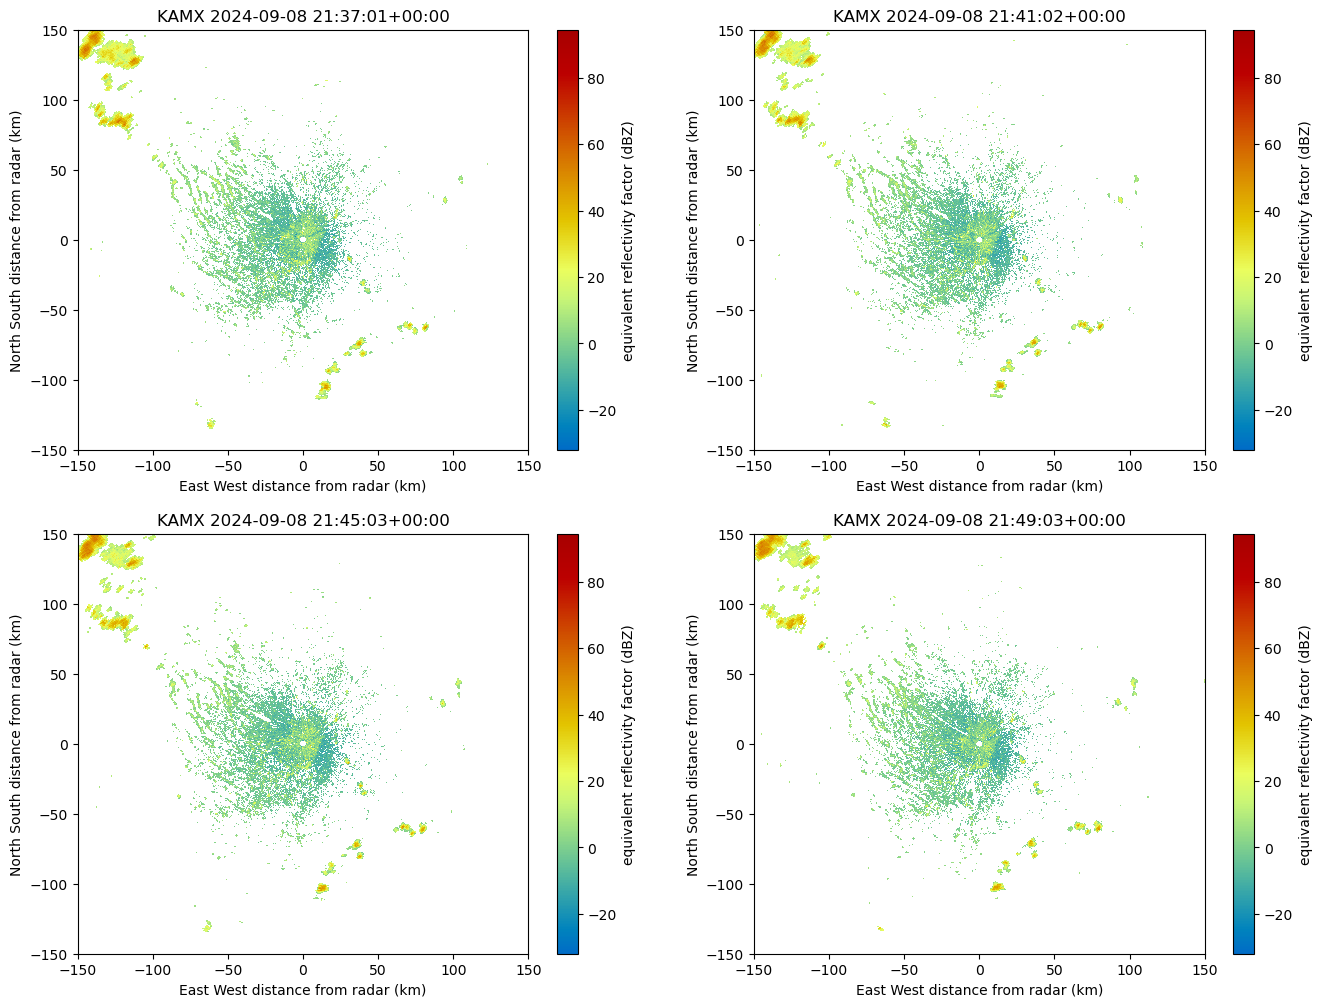

In [120]:
fig = plt.figure(figsize=(16,12))
for i,scan in enumerate(results.iter_success(),start=1):
    ax = fig.add_subplot(2,2,i)
    radar = scan.open_pyart()
    display = pyart.graph.RadarDisplay(radar)
    display.plot('reflectivity',0,ax=ax,title="{} {}".format(scan.radar_id,scan.scan_time))
    display.set_limits((-150, 150), (-150, 150), ax=ax)
plt.savefig('./figures/nexrad_data_20240908.png')

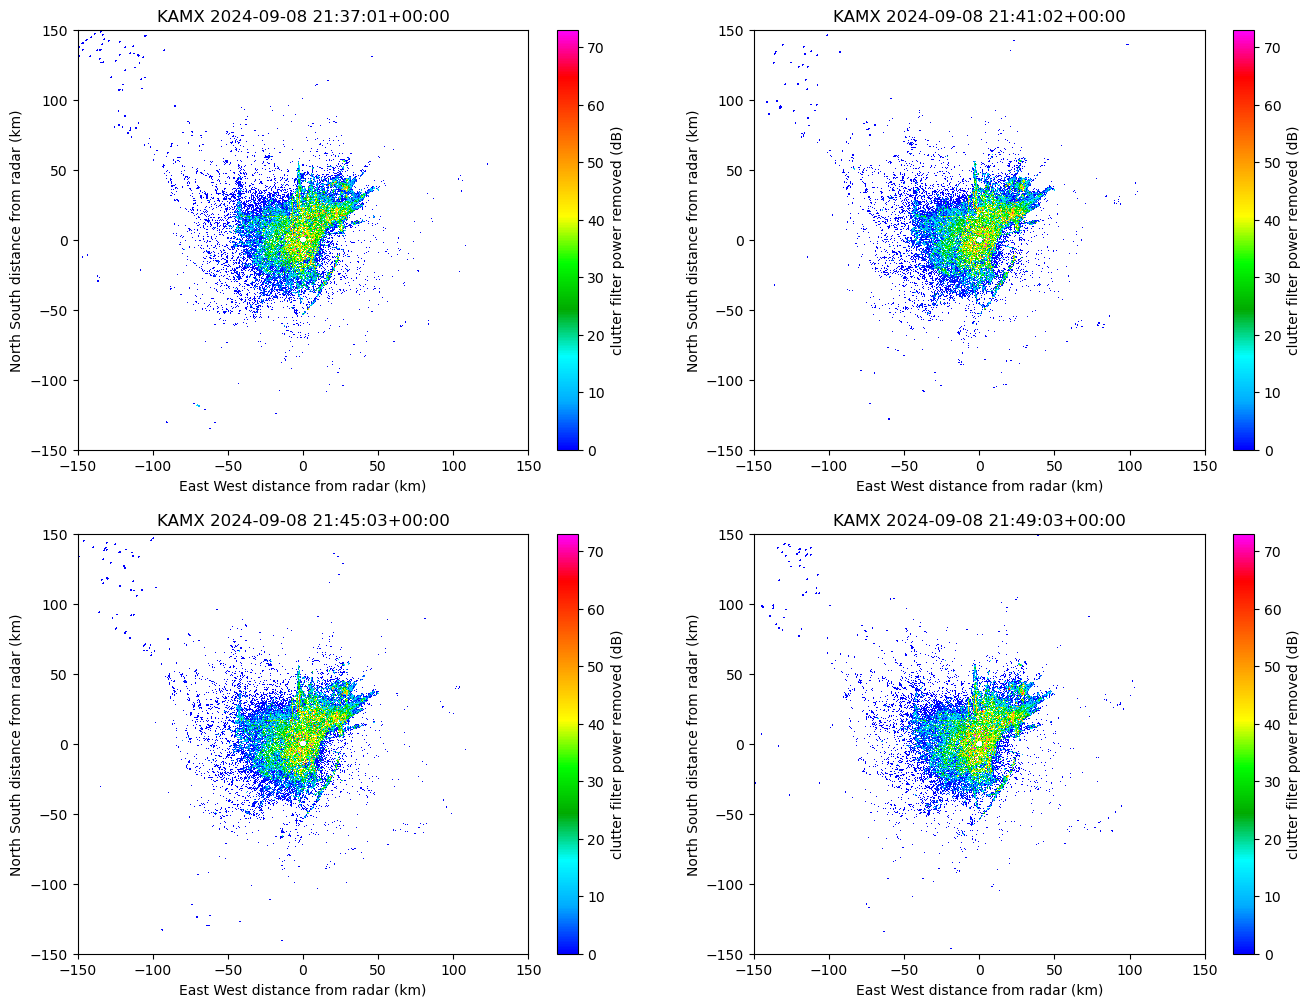

In [115]:
fig = plt.figure(figsize=(16,12))
for i,scan in enumerate(results.iter_success(),start=1):
    ax = fig.add_subplot(2,2,i)
    radar = scan.open_pyart()
    display = pyart.graph.RadarDisplay(radar)
    display.plot('clutter_filter_power_removed',0,ax=ax,title="{} {}".format(scan.radar_id,scan.scan_time))
    display.set_limits((-150, 150), (-150, 150), ax=ax)
plt.savefig('./figures/nexrad_data_20240908.png')

In [130]:
site_lon = -80.1341  # longitude in degrees
site_lat = 25.7826  # latitdue in degrees
for i,scan in enumerate(results.iter_success(),start=1):
    ax = fig.add_subplot(2,2,i)
    radar = scan.open_pyart()
    ds = pyart.util.columnsect.get_field_location(radar, site_lat, site_lon)
    # filter if below 15 then probably not raining (holly norton advice to remove ground clutter)
    ds['rain']=ds.reflectivity
    # Apply the conditional operation on var2 based on var1
    ds['rain'] = xr.where(ds['reflectivity'] < 15, 0, xr.where(ds['reflectivity'] >= 15, 1, ds['reflectivity']))
    if i==1:
        ds_all = ds.isel(height=0)
    else:
        ds_all = xr.concat([ds_all, ds.isel(height=0)],dim = 'time')

In [134]:
# now do for more data, let's make a timeseries
results = conn.download(scans, templocation)

Downloaded KAMX20240908_213701_V06
Downloaded KAMX20240908_215717_V06
Downloaded KAMX20240908_214503_V06
Downloaded KAMX20240908_215717_V06_MDM
Downloaded KAMX20240908_220117_V06
Downloaded KAMX20240908_215316_V06
Downloaded KAMX20240908_214903_V06
Downloaded KAMX20240908_220917_V06
Downloaded KAMX20240908_221317_V06
Downloaded KAMX20240908_222519_V06
Downloaded KAMX20240908_220517_V06
Downloaded KAMX20240908_214102_V06
Downloaded KAMX20240908_222118_V06
Downloaded KAMX20240908_222927_V06
Downloaded KAMX20240908_223734_V06
Downloaded KAMX20240908_223327_V06
Downloaded KAMX20240908_221718_V06
Downloaded KAMX20240908_225410_V06
Downloaded KAMX20240908_225817_V06
Downloaded KAMX20240908_224141_V06
Downloaded KAMX20240908_225817_V06_MDM
Downloaded KAMX20240908_224548_V06
Downloaded KAMX20240908_230231_V06
Downloaded KAMX20240908_231053_V06
Downloaded KAMX20240908_230652_V06
Downloaded KAMX20240908_224949_V06
Downloaded KAMX20240908_231910_V06
Downloaded KAMX20240908_233227_V06
Downloaded K

In [140]:
site_lon = -80.1341  # longitude in degrees
site_lat = 25.7826  # latitdue in degrees
for i,scan in enumerate(results.iter_success(),start=1):
    if '_MDM' in str(scan):
        continue
    radar = scan.open_pyart()
    ds = pyart.util.columnsect.get_field_location(radar, site_lat, site_lon)
    ds['rain']=ds.reflectivity
    # Apply the conditional operation on var2 based on var1
    ds['rain'] = xr.where(ds['reflectivity'] < 15, 0, xr.where(ds['reflectivity'] >= 15, 1, ds['reflectivity']))
    if i==1:
        ds_all = ds.isel(height=0)
    else:
        ds_all = xr.concat([ds_all, ds.isel(height=0)],dim = 'time')

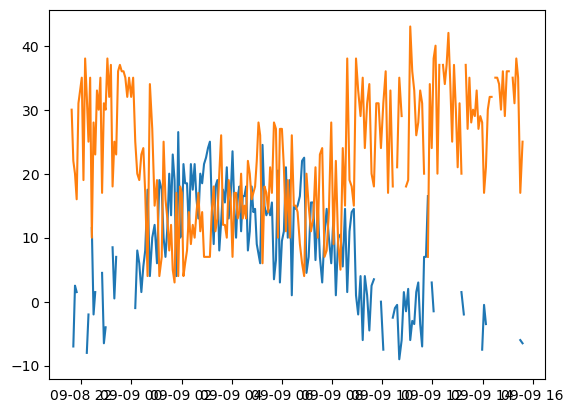

In [141]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(ds_all.base_time,ds_all.reflectivity)
plt.plot(ds_all.base_time,ds_all.clutter_filter_power_removed)

In [20]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pyart

In [16]:
aws_nexrad_level3_velocity_file = (
    "s3://unidata-nexrad-level3/HGX_N0U_2022_03_22_12_01_25"
)
aws_nexrad_level3_reflectivity_file = (
    "s3://unidata-nexrad-level3/HGX_N0Q_2022_03_22_12_01_25"
)

In [17]:
radar_level3_velocity = pyart.io.read_nexrad_level3(aws_nexrad_level3_velocity_file)
radar_level3_reflectivity = pyart.io.read_nexrad_level3(
    aws_nexrad_level3_reflectivity_file
)

In [18]:
print(
    "velocity radar object: ",
    list(radar_level3_velocity.fields),
    "reflectivity radar object: ",
    list(radar_level3_reflectivity.fields),
)

velocity radar object:  ['velocity'] reflectivity radar object:  ['reflectivity']


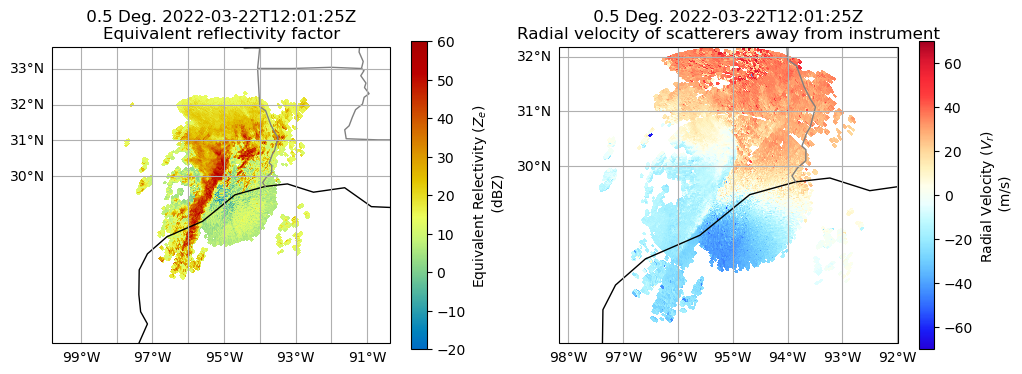

In [21]:
fig = plt.figure(figsize=(12, 4))
reflectivity_display = pyart.graph.RadarMapDisplay(radar_level3_reflectivity)

ax = plt.subplot(121, projection=ccrs.PlateCarree())

reflectivity_display.plot_ppi_map(
    "reflectivity",
    ax=ax,
    colorbar_label="Equivalent Relectivity ($Z_{e}$) \n (dBZ)",
    vmin=-20,
    vmax=60,
)

velocity_display = pyart.graph.RadarMapDisplay(radar_level3_velocity)

ax = plt.subplot(122, projection=ccrs.PlateCarree())

velocity_display.plot_ppi_map(
    "velocity",
    ax=ax,
    colorbar_label="Radial Velocity ($V_{r}$) \n (m/s)",
    vmin=-70,
    vmax=70,
)

In [23]:
# Author: Maxwell Grover (mgrover@anl.gov)
# License: BSD 3 clause

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

import pyart
from pyart.testing import get_test_data

# Read in some test data
filename = get_test_data("swx_20120520_0641.nc")
radar = pyart.io.read(filename)